In [5]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import astropy.units as u
import pandas as pd

from scipy.stats import binned_statistic
from scipy.interpolate import interp1d

from matplotlib.backends.backend_pdf import PdfPages

# Data acquistion and handling

In [6]:
# Take data from TESS
search_result_s1 = lk.search_lightcurve('TIC 206544316', mission='TESS', sector=1)[0]

# Assign to variable 
lc = search_result_s1.download() 

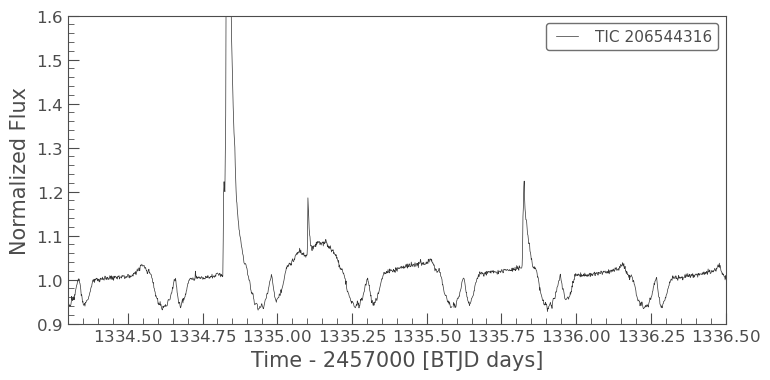

In [7]:
# # Take data from TESS
# search_result_s1 = lk.search_lightcurve('TIC 206544316', mission='TESS', sector=1)[0]

# # Assign to variable 
# lc = search_result_s1.download() 
norm_lc = lc.normalize() 

# Preview data
%matplotlib inline

ax = norm_lc.plot()
ax.set_ylim(0.9,1.6)
ax.set_xlim(1334.3,1336.5)

#save.savefig()
plt.show()

# Move to pandas
lc_time = norm_lc.time.value
lc_flux = norm_lc.flux.value
lc_flux_err = norm_lc.flux_err.value

df_lc = pd.DataFrame(lc_time,columns=['Time'])
df_lc['Flux'] = lc_flux
df_lc['Error'] = lc_flux_err

# First analysis: using folded light curve (pre-flare)

Period is =  0.3216891840137279


<Figure size 1000x600 with 0 Axes>

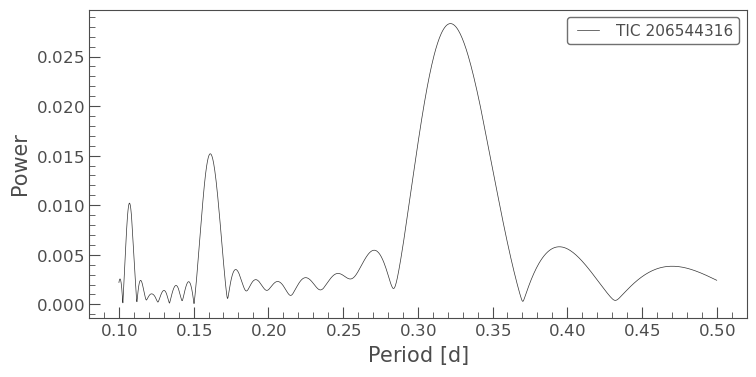

In [8]:
# Cut the data to pre-flare only
trunc = norm_lc.truncate(before=1332, after=1334.5)
# trunc = norm_lc.truncate(before=1325, after=1334)
# trunc = norm_lc

# Periodogram
pg = trunc.to_periodogram(method='lombscargle',minimum_period=0.1, maximum_period=0.5,oversample_factor=100)
P = pg.period_at_max_power.value

%matplotlib inline
plt.figure(figsize=[10,6])
pg.plot(view='period')

# P = 0.32175851277204937

print('Period is = ',P)

# Fold the pre-flare only data
fold = trunc.fold(period=1*P,normalize_phase=True)

# Preview the data
# %matplotlib inline

# plt.figure(figsize=[8,4])
# ax = fold.plot()
#plt.savefig('Output/Folded.pdf')

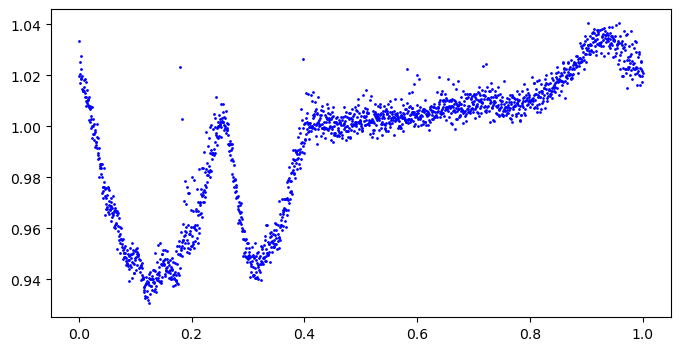

In [9]:
# Move to pandas dataframe
time = fold.time.value
flux = fold.flux.value
error = fold.flux_err.value

for i in range(len(time)):
    if (time[i] < 0):
        time[i] = time[i]+1

df_fold = pd.DataFrame(time,columns=['Phase'])
df_fold['Flux'] = flux
df_fold['Error'] = error
df_fold = df_fold.sort_values(by=['Phase'],ignore_index=True)

# Data preview
%matplotlib inline

plt.figure(figsize=[8,4])
plt.scatter(df_fold.Phase,df_fold.Flux,s=1,color='blue')
#plt.savefig('Output/Folded - PreBinned.pdf')

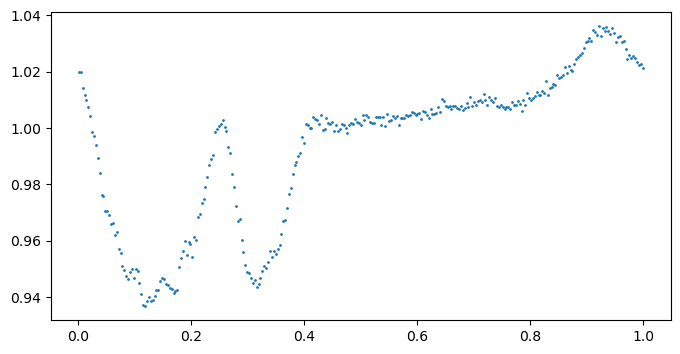

In [10]:
# Bin the data
num_bins = np.linspace(0,1.0,300)
df_bin = df_fold.groupby(pd.cut(df_fold.Phase,num_bins)).Flux.median().reset_index()

df_bin['Center'] = df_bin['Phase'].apply(lambda x: x.mid)

# Plot the binned data
%matplotlib inline

plt.figure(figsize=[8,4])
plt.scatter(df_bin['Center'],df_bin['Flux'],s=1)
#plt.savefig('Output/Folded - Binned.pdf')

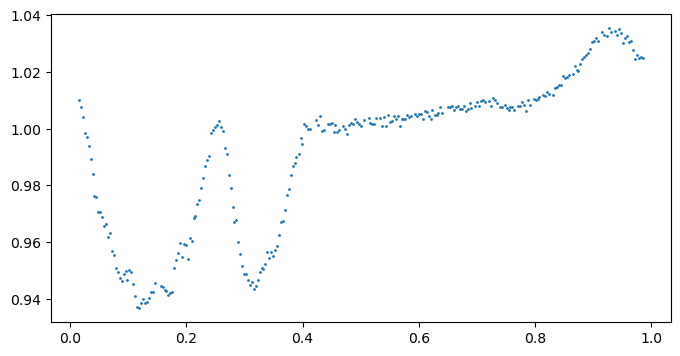

In [11]:
# Sigma-clip the binned folded curve

# Determine the rolling median 
df_bin['rol_med'] = df_bin['Flux'].rolling(9, center=True).median()

# Determine the rolling standard deviation
df_bin['rol_std'] = df_bin['Flux'].rolling(9, center=True).std()

# Sigma-clipped data criteria: data > local median (rol_med) + local standard deviation (rol_std). 
# Determining the sigma-clipping criteria for 1.5 sigma
df_bin['rol_crit'] = df_bin['rol_med'] + (1 * df_bin['rol_std'])

# Dropping the NaN
df_bin = df_bin.dropna()

# Sigma-clipping for 1.5 sigma
df_clip = df_bin.mask(df_bin['Flux'] > df_bin['rol_crit'])
df_clip = df_clip.dropna()

df_clip = df_clip.reset_index()

%matplotlib inline

# Plot the clipped data
%matplotlib inline

plt.figure(figsize=[8,4])
plt.scatter(df_clip['Center'],df_clip['Flux'],s=1)

#save.savefig()

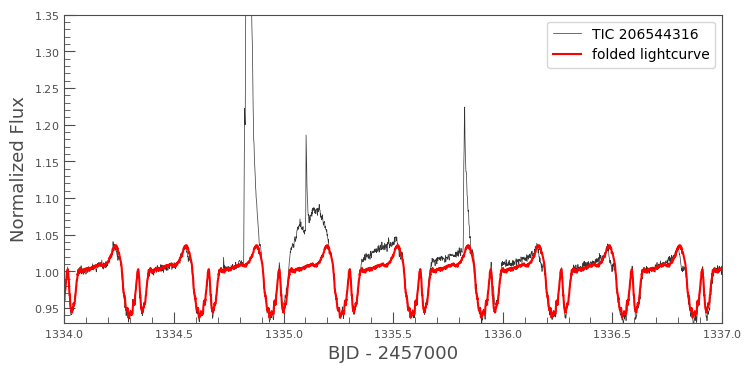

In [12]:
# Getting a lightcurve from the folded data

# Determine T0 and Tmax
T0 = 1325.6
Tmax = 1353.1792537401057

# Loop the folded lightcurve
phase = df_clip['Center']
fluks = df_clip['Flux']
j = len(phase)-1
n_i = ((Tmax - T0)/P) * j

t = []
f = []

for i in range(np.int64(n_i)):
    a = np.mod(i,j)
    b = np.floor_divide(i,j)
    x = (T0-0.031) + ((b+1)*P) + (P*phase[a])
    y = fluks[a]
    
    t.append(x)
    f.append(y)

df_mod = pd.DataFrame(t,columns=['Time']) 
df_mod['Flux'] = f

%matplotlib inline

# Plot the data
%matplotlib inline

# plt.figure(figsize=[10,6])

ax = lc.plot(normalize='True')
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.plot(t,f,color='red', label='folded lightcurve')
ax.set_ylim(0.93,1.35)
ax.set_xlim(1334,1337)
ax.set_xlabel('BJD - 2457000',fontsize=13)
ax.set_ylabel('Normalized Flux',fontsize=13)

plt.legend()

#save.savefig()

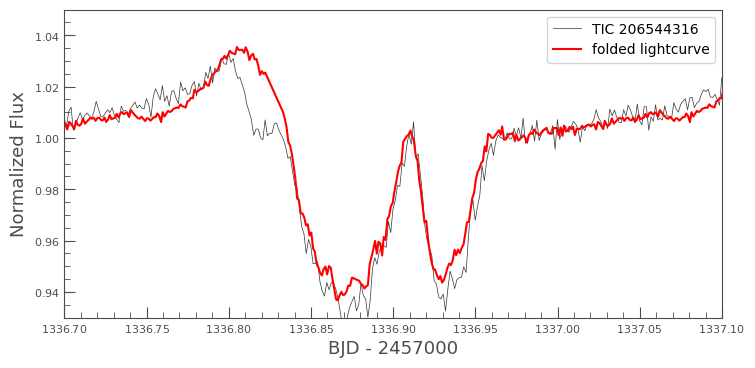

In [13]:
ax = lc.plot(normalize='True')
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.plot(t,f,color='red', label='folded lightcurve')
ax.set_ylim(0.93,1.05)
ax.set_xlim(1336.7,1337.1)
ax.set_xlabel('BJD - 2457000',fontsize=13)
ax.set_ylabel('Normalized Flux',fontsize=13)

plt.legend()

In [14]:
# Interpolate binned data
intrp = interp1d(t,f)

df_lc = df_lc[(df_lc['Time'] > 1334.5) & (df_lc['Time'] < 1336.5)]
df_lc = df_lc.reset_index()

Text(0, 0.5, 'Flux')

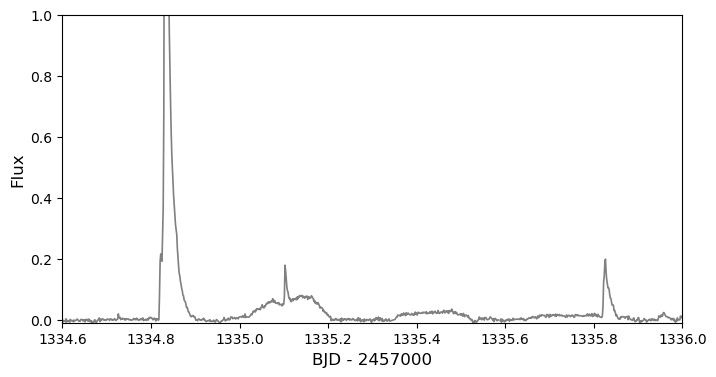

In [15]:
flare = []

for i in range(len(df_lc['Time'])):
    fl = df_lc['Flux'][i] - intrp(df_lc['Time'][i])

    flare.append(fl)

# Plot the data

%matplotlib inline

plt.figure(figsize=[8,4])
plt.plot(df_lc['Time'],flare,linewidth=1.2, color='grey')
plt.ylim(-0.01,1)
plt.xlim(1334.6,1336)

plt.xlabel('BJD - 2457000', fontsize=12)
plt.ylabel('Flux', fontsize=12)

#save.savefig()

In [16]:
# Convert time to radian
t0 = 1334.75

df_lc['Phase'] = (df_lc['Time'] - t0) / P

# Make flare a new dataframe
df_flare = pd.DataFrame(flare, columns=['Flux'])
df_flare['Time'] = df_lc['Time']
df_flare['Error'] = df_lc['Error']
df_flare['Phase'] = df_lc['Phase']

df_flare['Radian'] = df_flare['Phase'] * 2*np.pi

In [17]:
df_flare = df_flare[df_flare['Phase'] < 4]

In [18]:
# Drop additional flares

index_flare1 = df_flare[(df_flare['Phase'] > 1.075) & (df_flare['Phase'] < 1.125) & (df_flare['Flux'] > 0.076)].index
df_flare.drop(index_flare1,inplace=True)

index_flare2 = df_flare[(df_flare['Phase'] > 3.3) & (df_flare['Phase'] < 3.45) & (df_flare['Flux'] > 0.02)].index
df_flare.drop(index_flare2,inplace=True)

In [19]:
df_flare = df_flare.dropna()

(0.0, 1.0)

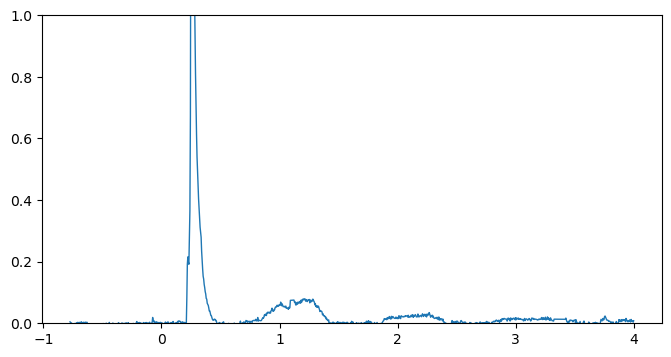

In [20]:
# Plot the data
%matplotlib inline

plt.figure(figsize=[8,4])
plt.plot(df_flare['Phase'],df_flare['Flux'],linewidth=1)
plt.ylim(0,1.0)

In [21]:
# maxidx = df_flare['Flux'].idxmax()
# df_flare['Error'][maxidx] = 0.5

In [22]:
df_flare

,Flux,Time,Error,Phase,Radian
0,0.004562,1334.501211,0.002800,-0.773382,-4.859303
1,0.002779,1334.502600,0.002798,-0.769064,-4.832175
2,-0.003995,1334.503989,0.002794,-0.764747,-4.805046
3,0.000637,1334.505378,0.002799,-0.760429,-4.777918
4,-0.003076,1334.506767,0.002795,-0.756112,-4.750790
...,...,...,...,...,...
1079,0.006833,1336.030410,0.002766,3.980272,25.008785
1080,0.008232,1336.031799,0.002768,3.984589,25.035913
1081,0.007226,1336.033188,0.002768,3.988907,25.063041
1082,0.003659,1336.034577,0.002764,3.993224,25.090169


In [23]:
# df_flare = df_flare[df_flare['Phase'] >= 0]
# df_flare = df_flare.drop(df_flare[df_flare['Phase'] < 0.6].index)
# df_flare = df_flare.drop(df_flare[df_flare['Phase'] > 1.5].index)
# df_flare['Flux'] = np.where(df_flare['Phase'] < 0.6, 0, df_flare['Flux'])
# # df_flare = df_flare.mask(df_flare['Phase'] < 0.6)

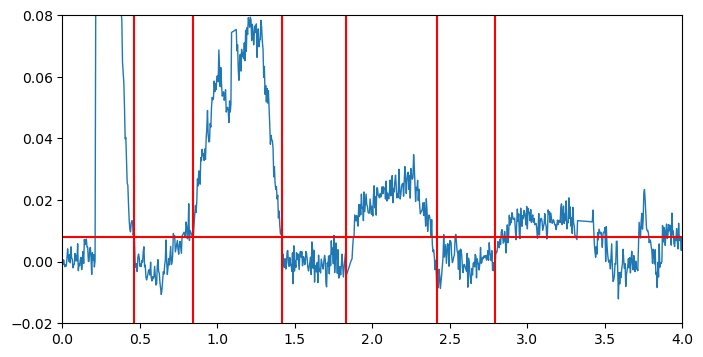

In [24]:
# Plot the data
%matplotlib inline

plt.figure(figsize=[8,4])
plt.plot(df_flare['Phase'],df_flare['Flux'],linewidth=1)
# plt.xlim(3,4)
plt.xlim(0,4)
plt.ylim(-0.02,0.08)
# plt.ylim(0,1)
plt.axvline(0.46, color='red')
plt.axvline(0.84, color='red')
plt.axhline(0.008, color='red')
plt.axvline(1.42, color='red')
plt.axvline(1.83, color='red')
plt.axvline(2.42, color='red')
plt.axvline(2.79, color='red')

In [25]:
df_flare[(df_flare['Phase'] > 0.84) & (df_flare['Phase'] < 0.89)]

,Flux,Time,Error,Phase,Radian
363,0.008404,1335.020667,0.002779,0.841393,5.286628
364,0.008773,1335.022056,0.002779,0.845710,5.313756
365,0.015526,1335.024834,0.002788,0.854346,5.368012
366,0.018262,1335.026223,0.002794,0.858663,5.395140
367,0.015968,1335.027612,0.002797,0.862981,5.422268
368,0.019549,1335.029001,0.002805,0.867298,5.449397
369,0.026843,1335.030389,0.002804,0.871616,5.476525
370,0.024661,1335.031778,0.002803,0.875934,5.503653
371,0.029458,1335.033167,0.002804,0.880251,5.530781
372,0.029359,1335.034556,0.002808,0.884569,5.557909


# Flare model

In [31]:
from astropy.constants import R_sun
import astropy.units as u

from funcs.model import FlareModulator, calculate_specific_flare_flux, aflare, aflare_decoupled

import emcee

# Emcee tries

In [79]:
# Time data (in radian)
phi = df_flare['Radian']
phi = np.array(phi)

# Flare lightcurve
flux = df_flare['Flux'] + 1
flux = np.array(flux)

# Lightcurve error
flux_err = df_flare['Error']
flux_err = np.array(flux_err)

# Stellar parameters 
# -----------------------

# Period of the star
P = 0.3216891840137279 * u.d
P = P.to(u.s)
#P = P.value

# Luminosity of the star
M_bol = 10.74
L_sun = 4e33 * u.erg / u.s
qlum = L_sun * np.power(10,((M_bol-4.8)/(-2.5)))
qlum = qlum.value

# Radius of the star
R = 0.46 * R_sun
R = R.to(u.cm)
R_in = R.value

# # Assumed inclination
# vsini = 70 * u.km / u.s

# v = (2*np.pi*R)/P
# v = v.to(u.km/u.s)

# sini = vsini/v
# sin_i = sini.value

# i = np.arcsin(sini)
# i = i.value

# # i = 75 * (np.pi / 180)

# Flare parameters
# ----------------------

# Flare amplitude
# a = 4
a = 7

# Time peak
# phi_a = 1.651455 # in radian
phi_a = 1.62

# FWHM of flare
# fwhm_1 = .05 * np.pi
# fwhm_2 = 0.22 * np.pi

fwhm_1 = .07 * np.pi
fwhm_2 = 0.35 * np.pi

# Flare latitude in rad
theta_a = 10*np.pi/180
# theta_a = 33*np.pi/180

# Flare longitude at t0
phi0 = 40*np.pi/180

# Assumed inclination

from uncertainties import ufloat
from uncertainties.umath import *

v = (2*np.pi*R)/P
v = v.to(u.km/u.s)

v = v.value

vsini = ufloat(63.38, 7.69)
sini = vsini/v

sini_nom = sini.n
sini_s = sini.s

i_mu = np.arcsin(sini.n)
i_s = np.arcsin(sini.n + sini.s) - np.arcsin(sini.n - sini.s)

i = (55*np.pi/180)
# i = (59*np.pi/180)

mu = i_mu
sigma = i_s

# flareparams = [(a, phi_a, fwhm_1, fwhm_2)]
flareparams = [(a, phi_a, fwhm_1)]
# params = np.array([theta_a, phi0, i, a, phi_a, fwhm_1, fwhm_2])
params = np.array([theta_a, phi0, i, a, phi_a, fwhm_1])

fn = FlareModulator(phi, qlum, R_in, flux, flux_err, iscoupled=True)

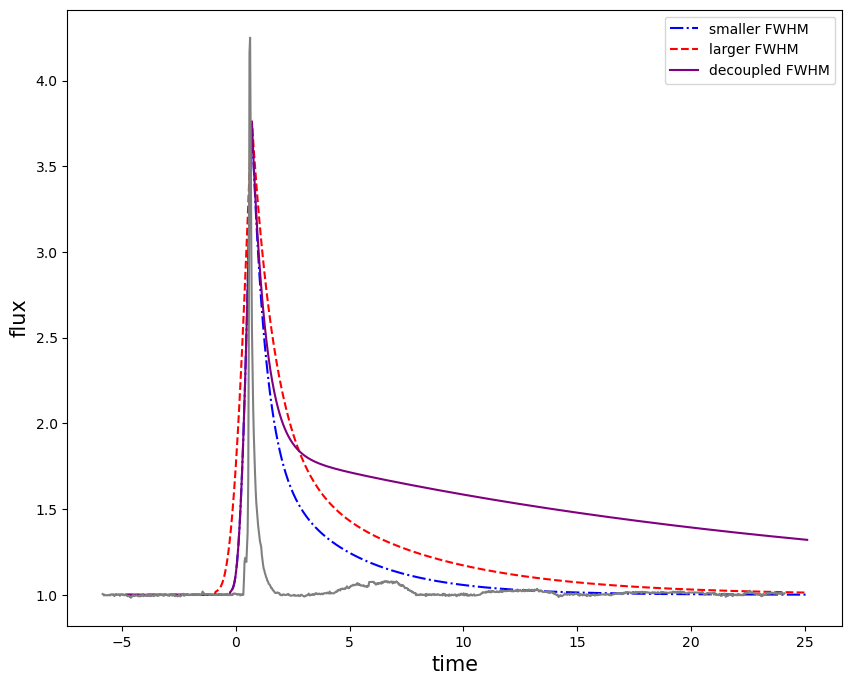

In [78]:
flare_1 = aflare(phi, params[1], params[2], params[0]*16)
flare_2 = aflare(phi, params[1], params[4], params[0]*16)
flare_d = aflare_decoupled(phi, params[1], params[2:4], params[0]*16)


%matplotlib inline
plt.figure(figsize=[10,8])
plt.plot(phi, flare_1+1, '-.', color='blue', label='smaller FWHM')
plt.plot(phi, flare_2+1, '--', color='red', label='larger FWHM')
plt.plot(phi, flare_d+1, color='purple', label='decoupled FWHM')
plt.plot(phi-1, flux, color='grey')
plt.xlabel('time', fontsize=15)
plt.ylabel('flux', fontsize=15)
plt.legend()

Text(0, 0.5, 'flux')

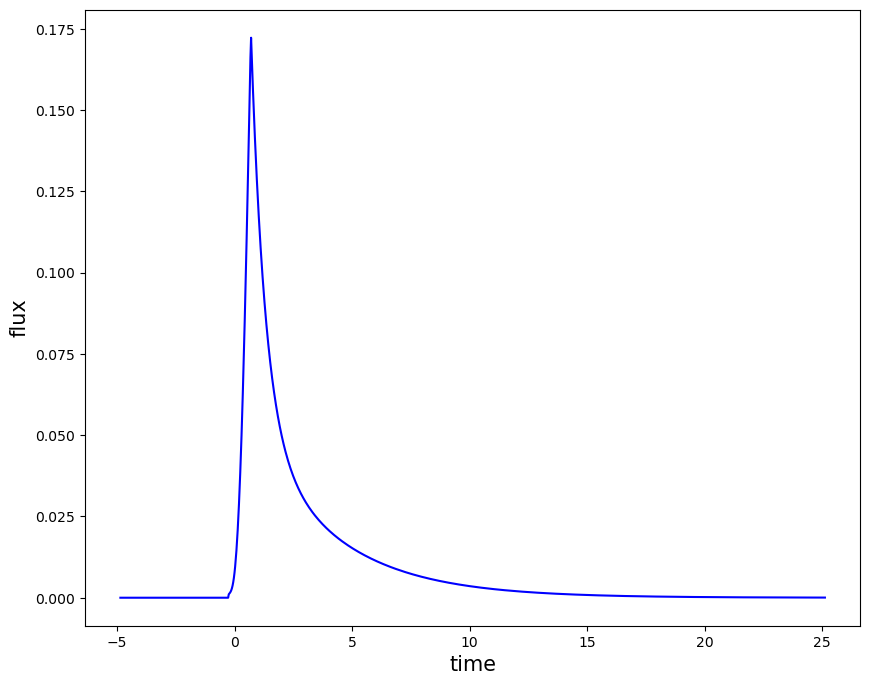

In [66]:
%matplotlib inline
plt.figure(figsize=[10,8])
plt.plot(phi, flare_1, color='blue', label='smaller FWHM')
plt.xlabel('time', fontsize=15)
plt.ylabel('flux', fontsize=15)

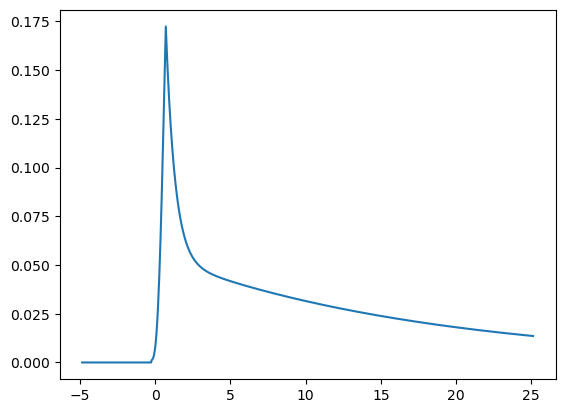

In [34]:
flare_d = aflare_decoupled(phi, params[1], params[2:4], params[0])

%matplotlib inline
plt.plot(phi, flare_d)

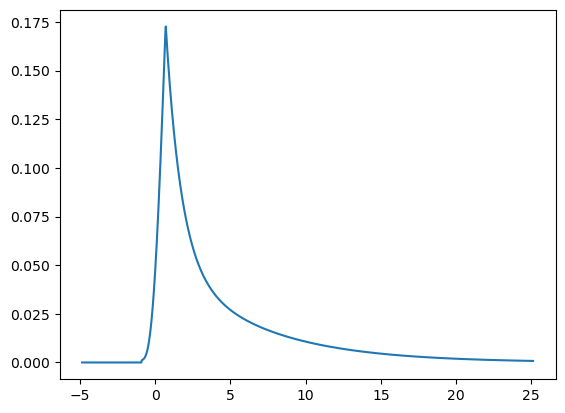

In [35]:
flare = aflare(phi, params[1], params[4], params[0])

%matplotlib inline
plt.plot(phi, flare)

Text(0, 0.5, 'Flux')

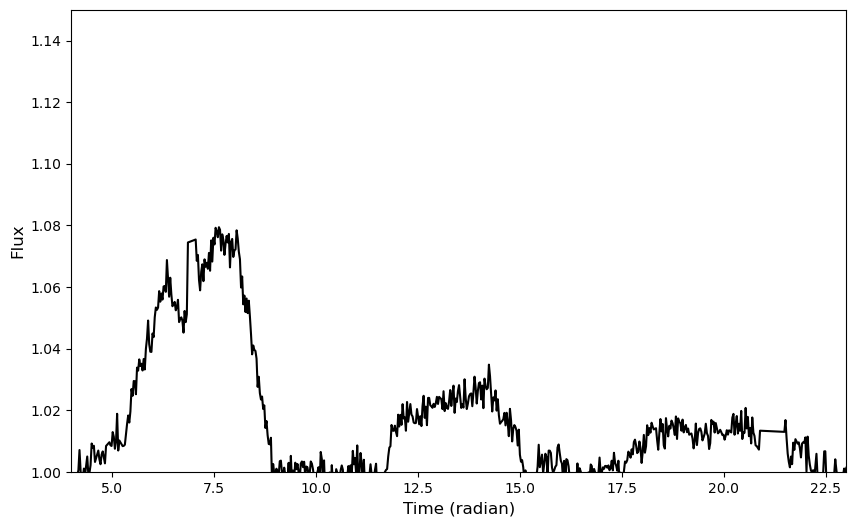

In [93]:
modulated_flare = fn.modulated_flux(theta_a, phi0, i, flareparams)

%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=[10, 6])
ax.plot(phi, flux, color='black')
# ax.plot(phi, modulated_flare, color='red')
# plt.ylim(1,5)
# plt.xlim(0.5,4)
plt.ylim(1,1.15)
plt.xlim(4,23)
# plt.title('Flare lightcurve', fontsize=15)
plt.xlabel('Time (radian)', fontsize=12)
plt.ylabel('Flux', fontsize=12)

In [358]:
def log_prior(par, mu, sigma):

    theta_a, phi0, i, a, phi_a, fwhm_1, fwhm_2 = par

    if 0 < theta_a < (np.pi/2) and (0*np.pi/180) < phi0 < (360*np.pi/180) and 2 < a < 8 and 1.5 < phi_a < 1.7 and 0 < fwhm_1 < (0.1*np.pi) and 0 < fwhm_2 < (0.25*np.pi):
        if 0 < i < (90*np.pi/180):
            return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-(0.5*(i-mu)**2/sigma**2)
        else: 
            return -np.inf
    else:
        return -np.inf


In [359]:
def log_probability(par, flux, flux_err):
    lp = log_prior(par, i_mu, i_s)

    if not np.isfinite(lp):
        return -np.inf
    return lp + -fn.log_likelihood(par)

In [360]:
# Set up the backend
filename = "new_prior-130823-3.h5"

In [361]:
initial = params

pos = initial + 1e-4 * np.random.randn(16, 7)
nwalkers, ndim = pos.shape

backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool, backend=backend, args=(flux, flux_err))
    sampler.run_mcmc(pos, 50000, progress=True)

100%|██████████| 50000/50000 [1:18:28<00:00, 10.62it/s]


In [36]:
reader = emcee.backends.HDFBackend('peak_masked-170723-8.h5')
samples = reader.get_chain(discard=20000, flat=True, thin=15)

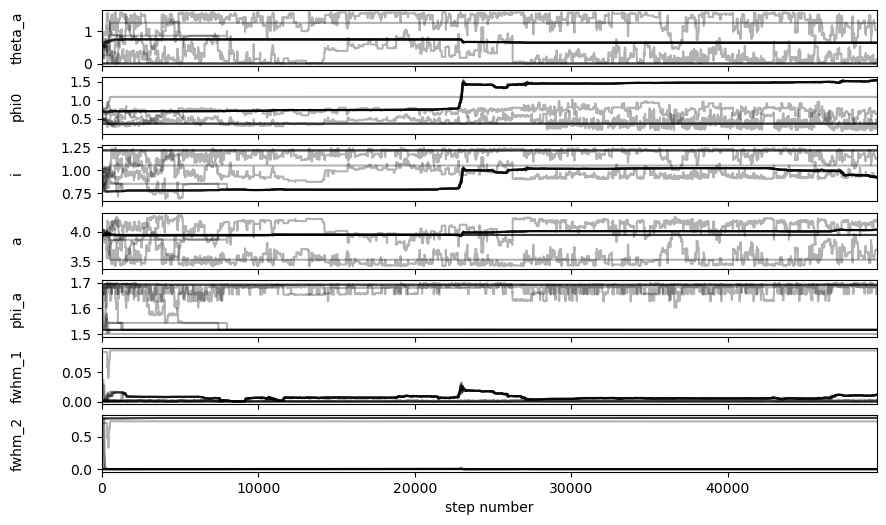

In [363]:
fig, axes = plt.subplots(7, figsize=(10, 6), sharex=True)
samples = sampler.get_chain(discard=500)
labels = ["theta_a", "phi0", "i", "a", "phi_a", "fwhm_1", "fwhm_2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [ 37.93796417 768.27151388  91.3029818  475.1888347  135.88788943
 236.90185956 152.79898077]

(21328, 7)


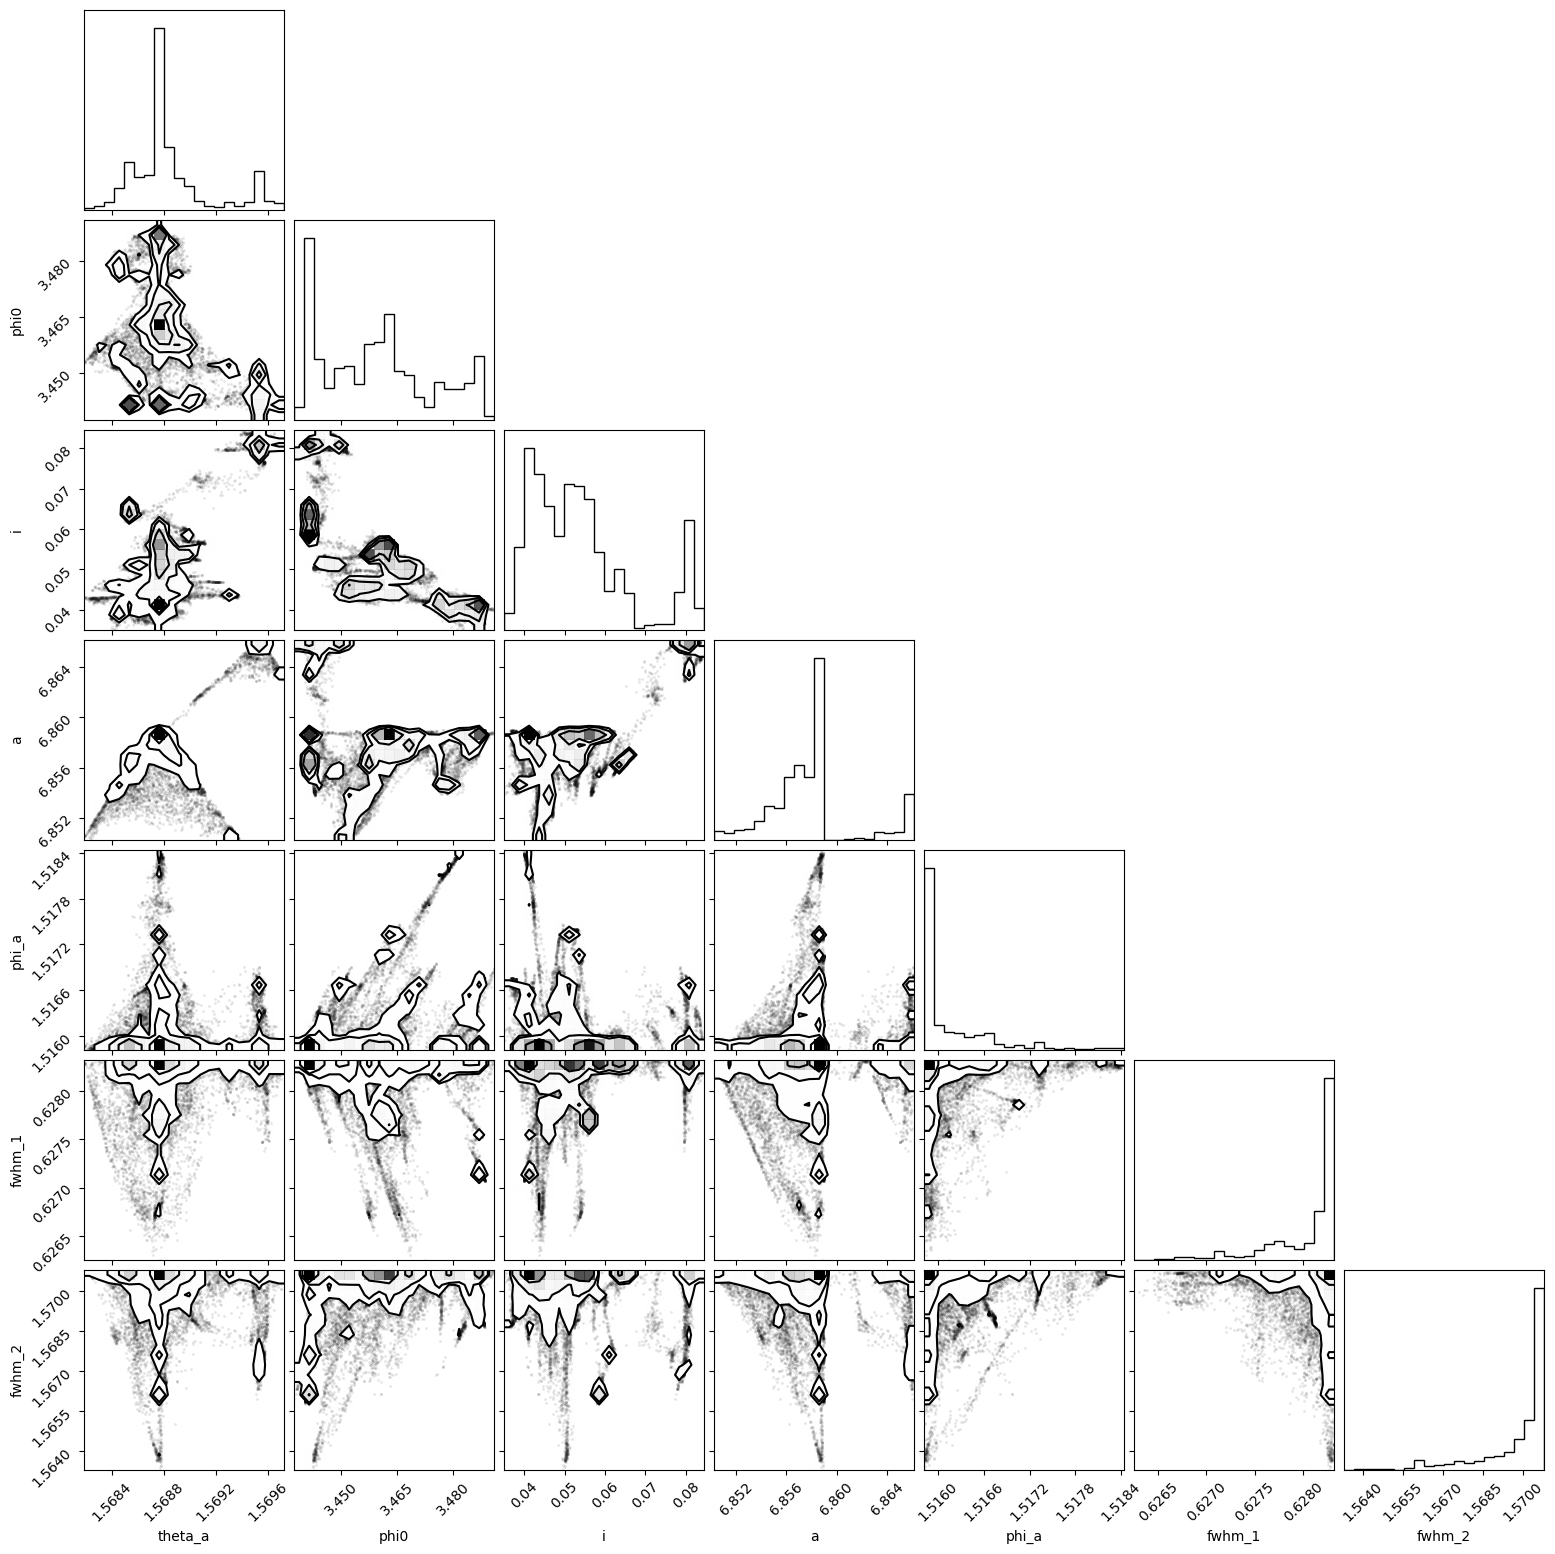

In [307]:
flat_samples = sampler.get_chain(discard=30000, thin=15, flat=True)
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels,
);

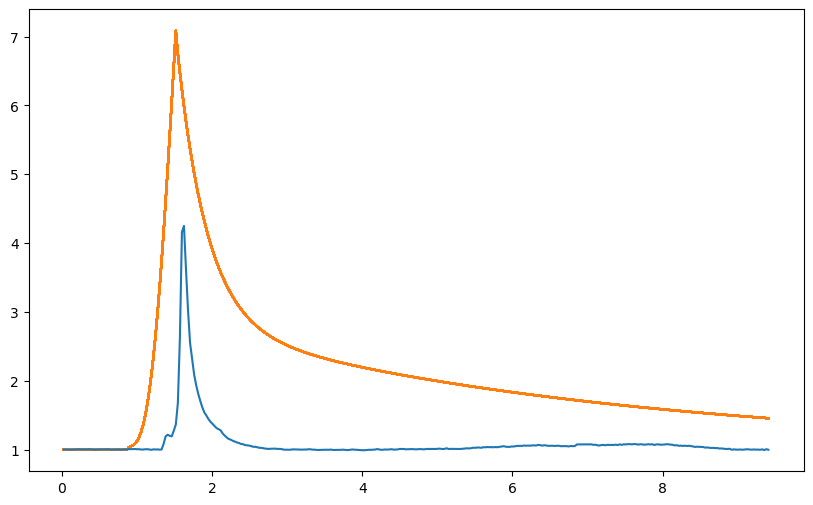

In [308]:
plt.figure(figsize=[10,6])
inds = np.random.randint(len(flat_samples), size=200)
for ind in inds:
    sample = flat_samples[ind]
    flareparams = [(sample[3], sample[4], sample[5], sample[6])]
    plt.plot(phi, fn.modulated_flux(sample[0], sample[1], sample[2], flareparams), "C1", alpha=0.1)
plt.plot(phi, flux, label='flux')
# plt.ylim(1,1.2)

In [309]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<>:6: DeprecationWarning: invalid escape sequence \m
<>:6: DeprecationWarning: invalid escape sequence \m
/tmp/ipykernel_6188/1529384300.py:6: DeprecationWarning: invalid escape sequence \m
  txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [74]:
np.rad2deg(0.001)

0.057295779513082325

NameError: name 'R_sun' is not defined